### 7.4 합성곱 / 풀링 계층 구현

In [1]:
import numpy as np
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [3]:
x[0].shape

(1, 28, 28)

In [7]:
x[0, 0, 0]

array([0.26531844, 0.38557199, 0.64528512, 0.35010988, 0.08953701,
       0.91861974, 0.7912761 , 0.32583924, 0.63700976, 0.79488025,
       0.99745216, 0.60916384, 0.67278501, 0.11149363, 0.94425923,
       0.40101133, 0.71768789, 0.880261  , 0.8566326 , 0.88553516,
       0.12730108, 0.14647156, 0.2292819 , 0.04694512, 0.75392043,
       0.66370834, 0.69684539, 0.54506793])

##### im2col = image to column<br>
3차원 입력 데이터를 2차원 행렬로 바꿈 !! 

In [ ]:
im2col(input_data, filter_h, filter_w, stride = 1, pad = 0)

In [11]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

# 배치크기 1, 채널3, 7x7
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride = 1, pad = 0)
print(col1.shape) 

# 배치크기10, 채널3, 7x7
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride = 1, pad = 0)
print(col2.shape)

(9, 75)
(90, 75)


In [12]:
# 합성곱
class Convolution:
    def __init__(self, W, b, stride = 1, pad = 0):
        self.W = W # 필터 (FN, C, FH, FW) 형상
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, F, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out
    
    # 역전파는 col2im 사용

In [13]:
# 풀링
class Pooling:
    def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 데이터 전개
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        # 최댓값
        out = np.max(col, axis = 1)
        # 모양 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

### 7.5 CNN 구현

In [17]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)] 

train loss:2.298929662865998
=== epoch:1, train acc:0.274, test acc:0.316 ===
train loss:2.295121370790783
train loss:2.291401381697643
train loss:2.2868007213114714
train loss:2.2822027695485345
train loss:2.261545995465575
train loss:2.2520884134867836
train loss:2.2256575516829655
train loss:2.216998910169053
train loss:2.1825309333063654
train loss:2.153034396953735
train loss:2.1283713584589923
train loss:2.105437667036912
train loss:2.0504922671492265
train loss:2.006589071787045
train loss:1.9028971763191087
train loss:1.8871957233965
train loss:1.8162374663088219
train loss:1.7122845811020784
train loss:1.6651967470998252
train loss:1.5820743124802257
train loss:1.517555948515778
train loss:1.4666514454991437
train loss:1.5007505451777183
train loss:1.3634180519550538
train loss:1.1223625985410843
train loss:1.066700073407979
train loss:1.0158520691345247
train loss:1.1076793685082738
train loss:0.9515976301218775
train loss:0.8028101082601902
train loss:0.850044201729865
train

train loss:0.2308510063489152
train loss:0.21630373923784635
train loss:0.25391313199148435
train loss:0.35000851736193744
train loss:0.22653684275558159
train loss:0.20459236244604054
train loss:0.14704647231814008
train loss:0.27044662029388783
train loss:0.16051515617236686
train loss:0.2075682505862477
train loss:0.21572120483866086
train loss:0.24492815287459652
train loss:0.29163124301377125
train loss:0.16784499852893053
train loss:0.1321140939678239
train loss:0.2003203571047989
train loss:0.19491567696389198
train loss:0.1967445746974165
train loss:0.2343266643165766
train loss:0.32131113983341786
train loss:0.32653016774050725
train loss:0.3388108459482172
train loss:0.21661229442195967
train loss:0.3300437732408524
train loss:0.38975197712244786
train loss:0.1761578823189599
train loss:0.3445416197590275
train loss:0.2574334380539344
train loss:0.3144249705445293
train loss:0.19966761626462923
train loss:0.2667650587370862
train loss:0.212472631049243
train loss:0.1663247021

train loss:0.09834913357640626
train loss:0.1440860084910287
train loss:0.12490588309042927
train loss:0.15219764994086696
train loss:0.18333662554075572
train loss:0.09128933776046783
train loss:0.1040456232651452
train loss:0.10405752911663982
train loss:0.09697408242975752
train loss:0.17506326071954315
train loss:0.1192466926323179
train loss:0.14551525803198545
train loss:0.10260176812434152
train loss:0.09420660664584986
train loss:0.10207565923857931
train loss:0.10699355750899793
train loss:0.09581482093916385
train loss:0.08168474077070947
train loss:0.14700944732095994
train loss:0.1742039543029032
train loss:0.14686429048921076
train loss:0.12455641714082369
train loss:0.1435655877752656
train loss:0.222260111681152
train loss:0.1938281604678871
train loss:0.08643462370976591
train loss:0.10255429982888974
train loss:0.09880550825849138
train loss:0.255742147980257
train loss:0.10382813149546596
train loss:0.11461101682578566
train loss:0.15073150484434975
train loss:0.24400

train loss:0.08316946353888655
train loss:0.1396993412816194
train loss:0.24238833456004627
train loss:0.09988980762113167
train loss:0.16629708697339043
train loss:0.1746926762868994
train loss:0.06223918240339307
train loss:0.06433211579982483
train loss:0.040744351468065314
train loss:0.05767182756221457
train loss:0.05718654893698563
train loss:0.10710932854151402
train loss:0.09081289902884672
train loss:0.09386295751876082
train loss:0.054794326022923216
train loss:0.15746113096955047
train loss:0.14219397153461397
train loss:0.09302288748184301
train loss:0.04639841368495072
train loss:0.1292228803824948
train loss:0.09492603490170015
train loss:0.04237069134447171
train loss:0.07194775303593526
train loss:0.07632005643765633
train loss:0.09202003520064174
train loss:0.14663737265557786
train loss:0.11921908389531227
train loss:0.1004449765142433
train loss:0.18666928441435396
train loss:0.17435820364719515
train loss:0.08805793954513075
train loss:0.03345909587007274
train loss

train loss:0.04257574685720034
train loss:0.059737616905538235
train loss:0.13760535946658645
train loss:0.08718970388049302
train loss:0.10016248574426352
train loss:0.057521895321574326
train loss:0.04739694890150899
train loss:0.1266469616603304
train loss:0.062240638253061205
train loss:0.056919787864130905
train loss:0.06179272895701526
train loss:0.08161472357554246
train loss:0.07188400767359457
train loss:0.03849846500635378
train loss:0.06125865798171601
train loss:0.060368863057129234
train loss:0.05711736643512036
train loss:0.04815405880748265
train loss:0.06642634777579054
train loss:0.036529534830420936
train loss:0.10041233826231304
train loss:0.05555413849965021
train loss:0.06938418373130123
train loss:0.040331543348421324
train loss:0.03921553011694183
train loss:0.06806135585591454
train loss:0.05468834017571794
train loss:0.05875489310381425
train loss:0.09473660482931326
train loss:0.06897421700040673
train loss:0.078462142499455
train loss:0.0988346481240447
train

train loss:0.03952978058908155
train loss:0.05559725278528165
train loss:0.04802542317372328
train loss:0.10019210476784361
train loss:0.034771881674226256
train loss:0.055531391301056984
train loss:0.09552700068791734
train loss:0.04904231769680385
train loss:0.020035616428408978
train loss:0.03526840521748436
train loss:0.14018894593343467
train loss:0.12095559097925376
train loss:0.04098402194795114
train loss:0.06313200747050887
train loss:0.07905556079040194
train loss:0.027447154820806667
train loss:0.11696716873786149
train loss:0.04844219227698418
train loss:0.06159131627354577
train loss:0.06945605224260726
train loss:0.055420332616796214
train loss:0.06541201518419468
train loss:0.04236467163622476
train loss:0.05220854264917283
train loss:0.05466955051171106
train loss:0.06292180957004335
train loss:0.1304370010473153
train loss:0.0721041175806005
train loss:0.047461964163836974
train loss:0.029311043840427778
train loss:0.05507180369856746
train loss:0.06269205487992478
tra

train loss:0.026585770315518738
train loss:0.07667121352393644
train loss:0.016779599382384616
train loss:0.06492179466074084
train loss:0.03775387876613169
train loss:0.0729484103307552
train loss:0.11775416865231092
train loss:0.02749534229160896
train loss:0.04645294325091079
train loss:0.09935793601826128
train loss:0.03013760708638368
train loss:0.03764700907209737
train loss:0.01952391251003662
train loss:0.04698558304495255
train loss:0.05719223147102858
train loss:0.07592804467002312
train loss:0.046692124453522464
train loss:0.04858707912316115
train loss:0.07172949703512171
train loss:0.02122632408748569
train loss:0.03650695236264538
train loss:0.09327954103358045
train loss:0.0393412276646156
train loss:0.06759282847968655
train loss:0.058101526717027695
train loss:0.10794219196539735
train loss:0.09292619838331749
train loss:0.05043795363115998
train loss:0.09354476741665417
train loss:0.029892156268167262
train loss:0.10299832618150093
train loss:0.04773024318335714
train

train loss:0.03196260590650217
train loss:0.018405304857437795
train loss:0.034896768129384685
train loss:0.040361644733725395
train loss:0.10407921265586309
train loss:0.02278872681867682
train loss:0.14374312215838622
train loss:0.057495846990010396
train loss:0.02349190016287542
train loss:0.06460418301182617
train loss:0.052508057908252394
train loss:0.021160666864437697
train loss:0.053704424536408536
train loss:0.03669295106864681
train loss:0.032235367141156115
train loss:0.02164772336450087
train loss:0.03271658294912657
train loss:0.06444112528239365
train loss:0.042163989459826724
train loss:0.08126233977244926
train loss:0.06707328021814027
train loss:0.033757369248358426
train loss:0.04244189091069443
train loss:0.03236620223312211
train loss:0.07065974895982223
train loss:0.026185904689774008
train loss:0.05910134753118193
train loss:0.015326377814519596
train loss:0.05812511862782809
train loss:0.04177849073968795
train loss:0.04917716747656589
train loss:0.01051608544694

train loss:0.10958000229097842
train loss:0.05115388578638382
train loss:0.013155321550727532
train loss:0.05539187763143236
train loss:0.008783180539989903
train loss:0.02298126038629218
train loss:0.045713482019948556
train loss:0.02693451375730679
train loss:0.04422681388078179
train loss:0.023268655120835122
train loss:0.028734843046981977
train loss:0.019970142677498616
train loss:0.018623916437570675
train loss:0.034533677103067976
train loss:0.07417036095754327
train loss:0.04686250583675605
train loss:0.06355341702720997
train loss:0.02770483985684594
train loss:0.02290368393707687
train loss:0.003940465201359597
train loss:0.026751788758218032
train loss:0.004144329391945967
train loss:0.05422343689800163
train loss:0.02470075950044051
train loss:0.01926896315060153
train loss:0.011496688375707793
train loss:0.06097381302185582
train loss:0.02476576433560127
train loss:0.014038786817599071
train loss:0.057562184099936235
train loss:0.049739972688500715
train loss:0.07729953808

train loss:0.00915488530603309
train loss:0.008257991993931586
train loss:0.057683141494418354
train loss:0.048272428254726385
train loss:0.013593977728115277
train loss:0.06406185846485885
train loss:0.03444708183908311
train loss:0.017893567996562307
train loss:0.040870230918513474
train loss:0.026949194732851747
train loss:0.005733554319243014
train loss:0.04853980264349986
train loss:0.03969105469804096
train loss:0.019328352729414265
train loss:0.04488515658637865
train loss:0.030026021860556366
train loss:0.0334759698461667
train loss:0.028466795538455866
train loss:0.008395974962603702
train loss:0.021040113385494292
train loss:0.02119028888923808
train loss:0.09589831546298899
train loss:0.029689363171261883
train loss:0.06966773172767673
train loss:0.029715605062561257
train loss:0.03719487911654639
train loss:0.02704303647165142
=== epoch:5, train acc:0.981, test acc:0.985 ===
train loss:0.05376256371837512
train loss:0.01128760879037516
train loss:0.024378326916914977
train 

train loss:0.02539244518296139
train loss:0.01950841182220626
train loss:0.00187554049603416
train loss:0.020740847047144864
train loss:0.016261561375949998
train loss:0.0433194266560586
train loss:0.06605932759991254
train loss:0.04499107270210577
train loss:0.029840042203444102
train loss:0.01956862544049569
train loss:0.09176863021236786
train loss:0.003955598725411526
train loss:0.004067595743031952
train loss:0.055873205908445626
train loss:0.009130002167161021
train loss:0.018029087505061617
train loss:0.026839242147532864
train loss:0.01396608619685469
train loss:0.04967872916671984
train loss:0.027202220358501575
train loss:0.19733425262148344
train loss:0.0051222322230325325
train loss:0.08738995115083968
train loss:0.011699185818717397
train loss:0.033385137514301125
train loss:0.06477330380125228
train loss:0.03424315707529555
train loss:0.01519305077197615
train loss:0.05284631670003478
train loss:0.04444665691679059
train loss:0.008917259956158474
train loss:0.040552512653

train loss:0.06084629410521418
train loss:0.003009243451016596
train loss:0.013496974864599807
train loss:0.048239397709641675
train loss:0.008255869237427393
train loss:0.005059413439172189
train loss:0.051081376981853485
train loss:0.07514154478706735
train loss:0.021566290199814344
train loss:0.09852197236712175
train loss:0.05110873745266785
train loss:0.011243292645898722
train loss:0.02261177666146348
train loss:0.031204178810002783
train loss:0.021273765203581697
train loss:0.03250591896196598
train loss:0.014082045766697143
train loss:0.009650536191614217
train loss:0.0828032956632283
train loss:0.01237315963792059
train loss:0.022142337951101397
train loss:0.009427239420899252
train loss:0.00730791260576048
train loss:0.06708341211780829
train loss:0.002512463098874875
train loss:0.029759185707128256
train loss:0.018392669321690105
train loss:0.01169926233787657
train loss:0.037580413286437485
train loss:0.057629373847710434
train loss:0.00482150022361786
train loss:0.02481935

train loss:0.06544995095950945
train loss:0.02469223938905164
train loss:0.07120625672029583
train loss:0.0038341452333200765
train loss:0.0223168433727448
train loss:0.07201865486383306
train loss:0.02262059879371916
train loss:0.018486555172386444
train loss:0.016182869479111222
train loss:0.009066849313955875
train loss:0.01500575764820607
train loss:0.07821008706547995
train loss:0.040827688310001164
train loss:0.010896192807163535
train loss:0.007325010056897901
train loss:0.01722373043014831
train loss:0.04092888020061657
train loss:0.02704673941852184
train loss:0.03542007757718166
train loss:0.021409413072871968
train loss:0.004971957537801875
train loss:0.01291490331676426
train loss:0.025261180155514807
train loss:0.039449047656463405
train loss:0.01369142645098897
train loss:0.02935933078140504
train loss:0.08698660031648434
train loss:0.015960954345923373
train loss:0.023661163819458632
train loss:0.007263226742729275
train loss:0.02238668561170382
train loss:0.041919496410

train loss:0.02514368588167442
train loss:0.01313760512089532
train loss:0.03498544810773904
train loss:0.006502952154629141
train loss:0.0058926869307325495
train loss:0.07653432780454159
train loss:0.0047929906771181155
train loss:0.012785222882915863
train loss:0.014976954930236
train loss:0.00537129325392954
train loss:0.01488889151992983
train loss:0.023585404131046622
train loss:0.021089596577543633
train loss:0.00818743486543202
train loss:0.01093108705717456
train loss:0.005585802360370528
train loss:0.002623344826385157
train loss:0.017124488909411668
train loss:0.004359580721779766
train loss:0.021823299433731028
train loss:0.0032629572852207094
train loss:0.028975818322408805
train loss:0.0548811860425517
train loss:0.019565051475108338
train loss:0.03321452043424183
train loss:0.010771046067030752
train loss:0.013942197215941289
train loss:0.008101218976429014
train loss:0.02212605228136813
train loss:0.029513030768121177
train loss:0.02357640448500559
train loss:0.03515102

train loss:0.004716778882761218
train loss:0.02210909672081302
train loss:0.010955231034011319
train loss:0.017397137251617532
train loss:0.02809148292941948
train loss:0.0035026105264311207
train loss:0.013345364061930922
train loss:0.022849681104066443
train loss:0.07074882257990064
train loss:0.02205657457050184
train loss:0.00472638414975365
train loss:0.010868406016696874
train loss:0.005493207449875152
train loss:0.022037056904104704
train loss:0.006823936909412999
train loss:0.007269781441863397
train loss:0.025980801282016505
train loss:0.015558217929035738
train loss:0.009672610606645678
train loss:0.005900627745899346
train loss:0.0034442398934966547
train loss:0.007018220370625878
train loss:0.0062352672358710745
train loss:0.007794482025139506
train loss:0.007241910303204863
train loss:0.014384487860326057
train loss:0.022819316631208997
train loss:0.03607968166969237
train loss:0.012569196303579819
train loss:0.016437627269469617
train loss:0.0015391525436513891
train loss

train loss:0.012965641408267677
train loss:0.010113959101169858
train loss:0.004209913439382621
train loss:0.004618579382267621
train loss:0.015551226056775953
train loss:0.00914109890905486
train loss:0.008806086393520941
train loss:0.0016803924532372968
train loss:0.03595490303138532
train loss:0.00697695865650613
train loss:0.007518590180302323
train loss:0.007736119340105071
train loss:0.014095292195537465
train loss:0.04845753322856754
train loss:0.011612523582488252
train loss:0.014724524798962508
train loss:0.02923608408163424
train loss:0.004144938246189805
train loss:0.004002591439990549
train loss:0.0037044377214526304
train loss:0.012171283557617561
train loss:0.03858138255553349
train loss:0.009558606715315976
train loss:0.0016908308921794605
train loss:0.014120406450899908
train loss:0.0125978973923117
train loss:0.0015144249561794684
train loss:0.008025498828651159
train loss:0.004669239795634202
train loss:0.012098130795431155
train loss:0.01739435711811561
train loss:0.

train loss:0.0023864557357447225
train loss:0.005802065678927564
train loss:0.032700244183847704
train loss:0.013183910529639891
train loss:0.08320364048635304
train loss:0.01369261839122542
train loss:0.04435874853928845
train loss:0.0627656787158138
train loss:0.03689136260591435
train loss:0.005038079770530627
train loss:0.05421754566849759
train loss:0.003208075363415228
train loss:0.003569945576583019
train loss:0.028262981503489503
train loss:0.043899154830814566
=== epoch:8, train acc:0.988, test acc:0.98 ===
train loss:0.019968490825388027
train loss:0.010330808647634677
train loss:0.16385693138432791
train loss:0.006927344286802899
train loss:0.008842778306021282
train loss:0.013729542057820484
train loss:0.10816026520163695
train loss:0.010211607119072673
train loss:0.01802666659564194
train loss:0.015142743381216765
train loss:0.013440556947771133
train loss:0.005870906230955478
train loss:0.05837745226617153
train loss:0.13338870274297965
train loss:0.0062437852401508245
tr

train loss:0.04312553580492842
train loss:0.016201683153086108
train loss:0.010966757437524035
train loss:0.011405932979363168
train loss:0.005734574620511544
train loss:0.0024101317657861023
train loss:0.00873463277201456
train loss:0.008193208897514735
train loss:0.01277981042911731
train loss:0.01589691345179915
train loss:0.00619808917724728
train loss:0.006079991143397134
train loss:0.0013542579635941194
train loss:0.01825331662265307
train loss:0.04297140254696047
train loss:0.012219813686540742
train loss:0.00876895589071244
train loss:0.0028473072338673845
train loss:0.002888765597719922
train loss:0.011353295470000947
train loss:0.010347802422784502
train loss:0.01284082329840683
train loss:0.008939838044197082
train loss:0.038387105347077594
train loss:0.0019027457010047395
train loss:0.009233267090407307
train loss:0.005186456970873038
train loss:0.011200775166423893
train loss:0.014607213231700455
train loss:0.0020517251989212067
train loss:0.021005478982000197
train loss:0

train loss:0.0163909617407253
train loss:0.0739017652145632
train loss:0.03982678746180021
train loss:0.010206446136155855
train loss:0.005092950408395994
train loss:0.004412854935862272
train loss:0.01699128857537211
train loss:0.010379875553636248
train loss:0.060615680140705716
train loss:0.006546644458046531
train loss:0.020654564151938913
train loss:0.005601365844331828
train loss:0.005564054936685706
train loss:0.013952683696060526
train loss:0.004446751372894211
train loss:0.024636300890345863
train loss:0.005469979484922335
train loss:0.007371691994841006
train loss:0.012430626685875563
train loss:0.028108293195295442
train loss:0.00336897311762624
train loss:0.05131798677484525
train loss:0.020518000781108738
train loss:0.0023973895721710395
train loss:0.0074438729325659045
train loss:0.010631042005225837
train loss:0.07137214389571335
train loss:0.016615375152644638
train loss:0.0031272312022166226
train loss:0.00401220690679396
train loss:0.01024850733150397
train loss:0.008

train loss:0.002922063393891269
train loss:0.001406653882651375
train loss:0.004454491533809149
train loss:0.013841730314804427
train loss:0.004505055830178108
train loss:0.007925511825389846
train loss:0.0074842317016964475
train loss:0.006282685787232136
train loss:0.01975560716829367
train loss:0.011469142039720617
train loss:0.01619445865810103
train loss:0.004097267690180295
train loss:0.0038790758207902253
train loss:0.04045402885133174
train loss:0.004036770957419903
train loss:0.01279270566541036
train loss:0.009039663113551035
train loss:0.04765468798078532
train loss:0.004016710396550736
train loss:0.0019455230778382517
train loss:0.0012865805925892965
train loss:0.004505294944161595
train loss:0.01291928617130925
train loss:0.001676606967565635
train loss:0.02078350705511796
train loss:0.002031471367409136
train loss:0.004397091029803162
train loss:0.012307538701459675
train loss:0.00834784041239483
train loss:0.012778730879313529
train loss:0.006615379478022511
train loss:0

train loss:0.013022634601705125
train loss:0.0011207580574961803
train loss:0.005305469337069246
train loss:0.007358165730435255
train loss:0.038718387385858206
train loss:0.0005424368655549437
train loss:0.007975748262646937
train loss:0.019738596234956753
train loss:0.003039320230605018
train loss:0.013280714387895702
train loss:0.012435997055825211
train loss:0.021746753280762192
train loss:0.001017377991325137
train loss:0.0026752589412025528
train loss:0.006410944825133938
train loss:0.0029632421118367426
train loss:0.00904429834734813
train loss:0.03796936574376355
train loss:0.006886991440416201
train loss:0.018038081150777072
train loss:0.005315438065276703
train loss:0.01483710042353611
train loss:0.006197913068247882
train loss:0.014158448180844321
train loss:0.011226479380690029
train loss:0.003279248572018465
train loss:0.025580100291005447
train loss:0.024068144035129854
train loss:0.039379504728609266
train loss:0.0033217708005525066
train loss:0.001481288442254051
train 

train loss:0.012849190067146694
train loss:0.002499300713311224
train loss:0.018609715563713058
train loss:0.024661370145567657
train loss:0.009304509456086416
train loss:0.0031978595170121522
train loss:0.004306688066763045
train loss:0.03152754271340335
train loss:0.014951715959999159
train loss:0.005273939525514517
train loss:0.0024249165757890836
train loss:0.011148007369649214
train loss:0.001493898957343658
train loss:0.03486098085343388
train loss:0.006902956145581073
train loss:0.01090262638598439
train loss:0.003251070544506792
train loss:0.009811758200023323
train loss:0.01169108941806899
train loss:0.003151176597150271
train loss:0.012784380880496493
train loss:0.014343528623874753
train loss:0.009268352258851788
train loss:0.03803543421528552
train loss:0.0006430378199649485
train loss:0.008007617441463498
train loss:0.030427434051807055
train loss:0.008252218971065489
train loss:0.0005346750141761448
train loss:0.005631948656483512
train loss:0.003747788076510342
train los

train loss:0.001744996881042707
train loss:0.01218693069264144
train loss:0.016890977158553717
train loss:0.0017941234577648181
train loss:0.0014323721052899416
train loss:0.004086007585051002
train loss:0.0023264005355233745
train loss:0.004964062940996313
train loss:0.005352525022062946
train loss:0.004218882827000397
train loss:0.011770083186907363
train loss:0.0033559536422687565
train loss:0.0038443315788267373
train loss:0.00466019472336314
train loss:0.0046014928075697814
train loss:0.0013833797742480675
train loss:0.0270603644798041
train loss:0.0017508828912199813
train loss:0.005552384878536742
train loss:0.021483144759463668
train loss:0.0022497489506966067
train loss:0.0008458040035044482
train loss:0.004389988395207552
train loss:0.0015681691394694405
train loss:0.0035129110763898247
train loss:0.017750810150118895
train loss:0.0010300721844325859
train loss:0.003526261522376125
train loss:0.014674201163746426
train loss:0.0010009538368976757
train loss:0.00277807341923636

train loss:0.006173577037219062
train loss:0.0024466983447315187
train loss:0.02670516054709509
train loss:0.025186964367425197
train loss:0.003127202312551683
train loss:0.01258042507637269
train loss:0.012945322854959439
train loss:0.0003666876265578401
train loss:0.03007576983779639
train loss:0.0007023442292339837
train loss:0.009317162830092108
train loss:0.02799674616900559
train loss:0.008107733914262867
train loss:0.007267589057614556
train loss:0.02733039369536112
train loss:0.00889466910886955
train loss:0.00896905109959321
train loss:0.04025349820883202
train loss:0.022070998702545183
train loss:0.009362030043632402
train loss:0.006620858968264539
train loss:0.0022784606615491396
=== epoch:11, train acc:0.991, test acc:0.983 ===
train loss:0.00776948024090144
train loss:0.004670067857044437
train loss:0.014023227502656943
train loss:0.017457985588719388
train loss:0.009476532063132368
train loss:0.009283243847433863
train loss:0.004094368663114983
train loss:0.00859494737541

train loss:0.001772608526821584
train loss:0.006955462828259857
train loss:0.0010867668435112182
train loss:0.00551281629690074
train loss:0.004381915528837837
train loss:0.008506498160835825
train loss:0.0021515659212039354
train loss:0.011342953425049176
train loss:0.0056527703454389965
train loss:0.0028774328839927784
train loss:0.0034666343888797536
train loss:0.0048830845608470955
train loss:0.004609989568129664
train loss:0.004806940221168984
train loss:0.003980117417083111
train loss:0.004989506010338504
train loss:0.0017975178657267804
train loss:0.001414745557023897
train loss:0.011505570324305906
train loss:0.015239052510217167
train loss:0.0004911275108676412
train loss:0.0020245870424944476
train loss:0.012744239204867131
train loss:0.006726440639659449
train loss:0.0016478454911011584
train loss:0.0016716247275360846
train loss:0.008306462302250761
train loss:0.0017345906182505957
train loss:0.0021687343463351934
train loss:0.02537017080343795
train loss:0.0119184125208799

train loss:0.0010465833958798894
train loss:0.0018570144483876774
train loss:0.002383157362786404
train loss:0.001968452072053101
train loss:0.014306770837133385
train loss:0.055073599043198584
train loss:0.0015597156229558515
train loss:0.010385422882371653
train loss:0.0013135998398425823
train loss:0.010021871777644464
train loss:0.0035600644103722036
train loss:0.0018961676419710987
train loss:0.0007704789292578465
train loss:0.01808297437364637
train loss:0.03192668051547848
train loss:0.0018299685742603307
train loss:0.011376428357802906
train loss:0.0026001057254869107
train loss:0.004008313480757036
train loss:0.0010019859901781803
train loss:0.0010747332736393163
train loss:0.0005290014445846574
train loss:0.004603451037662318
train loss:0.013598461198490253
train loss:0.0022091288739255655
train loss:0.0019248869154825637
train loss:0.002467719309501559
train loss:0.002396255604745747
train loss:0.010598525478966144
train loss:0.0020413930594884466
train loss:0.00200334079918

train loss:0.0011936176050617818
train loss:0.0033534616249100094
train loss:0.0031300548788819075
train loss:0.0008249036509229432
train loss:0.008913840922169522
train loss:0.0009679365986224662
train loss:0.0024960529706865658
train loss:0.004033429449037402
train loss:0.0027854666692918983
train loss:0.002061785494594161
train loss:0.0015490210634735138
train loss:0.003436249483736212
train loss:0.00048444658857250267
train loss:0.005075969185347533
train loss:0.0006263495535119792
train loss:0.0018997422525433797
train loss:0.0001993216236482307
train loss:0.04192308386175243
train loss:0.0015265799160290216
train loss:0.006348446131290072
train loss:0.007388939263812982
train loss:0.00041156014656848066
train loss:0.0047389449668771315
train loss:0.006544108373934614
train loss:0.0006563199794212172
train loss:0.0034567781568564976
train loss:0.00532581777396105
train loss:0.005730367343165657
train loss:0.009499256378262235
train loss:0.022381883905897747
train loss:0.0010945069

train loss:0.0018301975574387369
train loss:0.023289705565855186
train loss:0.0031834455107111613
train loss:0.027771341056868307
train loss:0.000163857457689915
train loss:0.0017832273189308484
train loss:0.00037885470600692786
train loss:0.001271313487582388
train loss:0.005592792182618929
train loss:0.002261275194513044
train loss:0.0016097878355119425
train loss:0.004219886831544983
train loss:0.003739427372881999
train loss:0.007978541975068866
train loss:0.0028292083173436094
train loss:0.0024295815009961566
train loss:0.0035881112993424802
train loss:0.003057173887791838
train loss:0.0025886523669332293
train loss:0.020153100589465237
train loss:0.0037581065363682126
train loss:0.006267012694495145
train loss:0.0019195836713645734
train loss:0.003144165774742995
train loss:0.004649157281275074
train loss:0.007988446293780298
train loss:0.0042623281910227125
train loss:0.005707642862985749
train loss:0.0004694031088266959
train loss:0.000520510434567914
train loss:0.0031914605100

train loss:0.0008693635554694379
train loss:0.005046741073488216
train loss:0.0025780693916227426
train loss:0.009402578596964804
train loss:0.00076971226769981
train loss:0.005225173007706671
train loss:0.0014516976384188322
train loss:0.005097099082139475
train loss:0.00039125235918166827
train loss:0.00041882212132308624
train loss:0.006823644894705701
train loss:0.0014500683446629782
train loss:0.0017225285288895351
train loss:0.0013225994128778426
train loss:0.0033568453958705263
train loss:0.014275740431954877
train loss:0.001974174776852314
train loss:0.003188711682166968
train loss:0.015102437041432083
train loss:0.0006678381139106462
train loss:0.0007260085230496959
train loss:0.015031839456406806
train loss:0.0027488080167224634
train loss:0.003509432310250056
train loss:0.0021388253782501426
train loss:0.014536441038991392
train loss:0.0017292161495803266
train loss:0.002622603830432926
train loss:0.0017828074790053603
train loss:0.0033179274955268765
train loss:0.0033866890

train loss:0.004481090823893079
train loss:0.03002160732447392
train loss:0.0016693244699092947
train loss:0.007364372011374597
train loss:0.005209364329098592
train loss:0.0027898153802398107
train loss:0.003147239866039635
train loss:0.002807932532300729
train loss:0.0013737759591938938
train loss:0.005806160494846596
train loss:0.0028793584591553347
train loss:0.00355827928704339
train loss:0.001307294170331416
train loss:0.001306436956270626
train loss:0.00449923225903414
train loss:0.00041255681543471765
train loss:0.0007649783959740895
train loss:0.0003090348497066217
train loss:0.002577267958203339
train loss:8.141836530057759e-05
train loss:0.0026719081531211037
train loss:0.005174975319802111
train loss:0.0031371468275228176
train loss:0.004859595977903977
train loss:0.0016513288235008347
train loss:0.0008505368543918017
train loss:0.002466591631228898
train loss:0.0008954000400306422
train loss:0.00016171732721471466
train loss:0.0007306648164299876
train loss:0.0029978529976

train loss:0.030228158541453224
train loss:0.0027337510144733066
train loss:0.0030018768301640804
train loss:0.008139554683646298
train loss:0.00298293686441215
train loss:0.005001398792337444
train loss:0.0016483185401866198
train loss:0.0003140953441897796
train loss:0.01903837468866842
train loss:0.004137727250354759
train loss:0.0014117149817273612
train loss:0.0022370885361266395
train loss:0.0028502635076560977
train loss:0.025435745025749138
train loss:0.002469282187137557
train loss:0.00420220279440332
train loss:0.0007560921424735006
train loss:0.023449747902302573
train loss:0.0035414286604516215
train loss:0.003068200635716427
train loss:0.0002583913645773289
train loss:0.02193780037126074
train loss:0.0030596660529282295
train loss:0.00010507554640392854
train loss:0.013687770529957873
train loss:0.00951576051073053
train loss:0.002202465606496534
train loss:0.005334530669577241
train loss:0.002735734947083651
train loss:0.0021735316004878966
train loss:0.003100163790200973

train loss:0.01658306619848773
train loss:0.0014679385000210435
train loss:0.022408784544125652
train loss:0.0027976119265252803
train loss:0.013550941825058414
train loss:0.001804090367697094
train loss:0.010784093349519429
train loss:0.011346841802452785
train loss:0.001663781437021048
train loss:0.0030460105661656105
train loss:0.0027027161838113654
train loss:0.014067903213112291
train loss:0.0006725529813355573
train loss:0.008838680114979725
train loss:0.01377341157804844
train loss:0.023160698176091885
train loss:0.0019440510404131056
train loss:0.0025270762009181745
train loss:0.002495500830668249
train loss:0.00287697582525236
train loss:0.0018169477220718094
train loss:0.004645446904926866
train loss:0.0014840812083459312
train loss:0.014020031278727219
train loss:0.01220198844398038
train loss:0.00813588081859013
train loss:0.0011286578054203378
train loss:0.014500170184036093
train loss:0.0012572641989497993
train loss:0.0013006223058850826
train loss:0.000406787777008104
t

train loss:0.010387615819929825
train loss:0.001787441694470665
train loss:0.0050960289125397355
train loss:0.006561160887294715
train loss:0.0009048901419721861
train loss:0.002341674903949666
train loss:0.00042634409436244835
train loss:0.002663679821173334
train loss:0.0005657971919579859
train loss:0.002748344400653024
train loss:0.00406547039608826
train loss:0.013097760527699325
train loss:0.0016871150356253199
train loss:0.003593178750306306
train loss:0.006869037880248126
train loss:0.008277081130385212
train loss:0.0060454101967613175
train loss:0.042758192033531824
train loss:0.0020891810278025665
train loss:0.0011682651911777188
train loss:0.0004940657093633964
train loss:0.004587295407853138
train loss:0.0017178930274827878
train loss:0.0037969308847181638
train loss:0.006814509579557871
train loss:0.0001860359720881184
train loss:0.0003373450054342684
train loss:0.014473323946508809
train loss:0.010913914883368549
train loss:0.007720269298503848
train loss:0.00070085334188

train loss:0.0009614957682860368
train loss:0.008893292915122987
train loss:0.0011945040356843495
train loss:0.0045299634135056
train loss:0.004382134730643164
train loss:0.0004339968033245205
train loss:0.0009232619128521339
train loss:0.0004561301575373488
train loss:0.001960941971037676
train loss:0.00013308709040216941
train loss:0.0047694086144852346
train loss:0.004677002317722664
train loss:0.026457142162401567
train loss:0.00033102104876709987
train loss:0.0018201352307998199
train loss:0.00043122724219844355
train loss:0.0009247970389268884
train loss:0.002100690421077849
train loss:0.00024984997470938207
train loss:0.0005163633556494091
train loss:0.0004890036690953002
train loss:0.010783887842087362
train loss:0.00019378906025213839
train loss:0.004300488007827362
train loss:0.0005993704668878193
train loss:0.0009088179639678949
train loss:0.0040806121828178875
train loss:0.0016672935064803967
train loss:0.001003523361472169
train loss:0.01312097967949913
train loss:0.001338

train loss:0.0005859188020482052
train loss:0.007228050014549463
train loss:0.00027309535361814605
train loss:0.0003067365320130472
train loss:0.001421281012211487
train loss:0.00017731127817354863
train loss:0.0006480745140248546
train loss:0.0067116071952597785
train loss:0.00011843777490182172
train loss:0.001415099169501884
train loss:0.0007311575970206144
train loss:0.0006808912582481028
train loss:0.0012155643614244302
train loss:0.0006648439069212546
train loss:0.0007005461269175171
train loss:0.0027226072573813607
train loss:0.008017260117565145
train loss:0.0019735633249450763
train loss:0.011894561215737455
train loss:0.014104279710698595
train loss:0.004497727655542689
train loss:0.0007092969939462004
train loss:0.007747266701191746
train loss:0.0030296328239687808
train loss:0.0006174436611926261
train loss:0.0016908139563457463
train loss:0.0027204460841106885
train loss:0.00011369955286085348
train loss:0.011105084314797755
train loss:0.0019138261024033633
train loss:0.00

train loss:0.00435511547398651
train loss:0.0018063040355529836
train loss:0.0020599865927246365
train loss:0.0020401145723221875
train loss:0.0010459720599464313
train loss:0.0066087845637005285
train loss:0.00015541071640658082
train loss:0.013874983337838685
train loss:0.002557917175748658
train loss:0.007384731211531503
train loss:0.0011604781982019325
train loss:0.003780410057641562
train loss:0.01101520947251423
train loss:0.0006287708748763912
train loss:0.002592525462661651
train loss:0.001835278392706174
train loss:0.002567912209450195
train loss:0.001843352363035722
train loss:0.0007514410339130252
train loss:0.0051467898463322505
train loss:0.009393672264195041
train loss:0.0019875345784682234
train loss:0.00187763247166052
train loss:0.0005886228146541254
train loss:0.0021335936269543106
train loss:0.00017504439381008585
train loss:0.0023929526266718774
train loss:0.000778821353978971
train loss:0.006864059694404973
train loss:0.0003551877641538571
train loss:0.001381587364

train loss:0.0021001529669681124
train loss:0.00032496638162859384
train loss:0.0005580354944086175
train loss:0.0005367994701166553
train loss:0.003108543861580515
train loss:0.000266793343815359
train loss:0.0007527550277074067
train loss:0.029328054902048883
train loss:0.006265768349367231
train loss:0.0007725633462121136
train loss:9.187715484524279e-05
train loss:0.0017897014667223982
train loss:0.0015537773245940306
train loss:0.0016197313316035026
train loss:0.0020036360791551
train loss:0.0009677466206360956
train loss:0.0028056959634559938
train loss:0.0002017443469842101
train loss:0.0022002091152815316
train loss:0.0005704995752668263
train loss:0.005689768691068306
train loss:0.0026761381713950884
train loss:0.001974378174412735
train loss:0.0006437478069937586
train loss:0.0017120338801127838
train loss:0.0001421069113141928
train loss:0.001370086117794025
train loss:0.0014164327506528316
train loss:0.0005698712258345461
train loss:0.0012395699932986936
train loss:0.006222

train loss:0.019708533826937644
train loss:3.665690706927926e-05
train loss:0.0008606355942984887
train loss:0.0015380307262292917
train loss:0.0017427888471926406
train loss:0.004416382084072698
train loss:0.008051015520499711
train loss:0.0012854278409347463
train loss:0.003885680049897054
train loss:0.003992249350982533
train loss:0.0015190332556572542
train loss:0.0019465920505015838
train loss:0.0008247186969826353
train loss:0.00044352054516019903
train loss:0.0005701693522916415
train loss:0.0021006252267649047
train loss:0.00020153329335756962
train loss:0.0006074870377695639
train loss:0.0010027065686415149
train loss:0.0021856164861740386
train loss:0.0022044823293990924
train loss:0.022211107787705294
train loss:0.0021695230188773433
train loss:0.0011446167520979236
train loss:0.0009224619539303723
train loss:0.009081398568612663
train loss:0.0020997878951102933
train loss:0.0007689123717610497
train loss:0.014372904315209262
train loss:0.001279320687300943
train loss:0.0015

train loss:0.0017159639483376927
train loss:0.009928272054276965
train loss:0.000571914771517167
train loss:3.673887537822256e-05
train loss:0.0022055720854284215
train loss:0.002020354837679741
train loss:0.0003057770495855063
train loss:0.003765227038826255
train loss:7.801661643843101e-05
train loss:0.0008252534862599232
train loss:0.0013903410661865831
train loss:0.00030170961100165107
train loss:0.0006809295867457775
train loss:0.004531100652466784
train loss:0.0029410147379518524
train loss:0.00016231017482050137
train loss:0.00014239777364533567
train loss:0.0017003772521956583
train loss:0.00032290460701378683
train loss:0.0019500915693551495
train loss:0.002249035933552474
train loss:0.0014792527235711604
train loss:0.0002904448988650218
train loss:0.0008343772390621444
train loss:0.0014530341344060078
train loss:0.002210433063743105
train loss:0.0017954928689172653
train loss:0.0013098268484434412
train loss:0.0017665749767866697
train loss:1.5885991100870073e-05
train loss:0

train loss:0.000447278359602528
train loss:0.00043741080004509165
train loss:0.01384654360183857
train loss:0.0003016303919025948
train loss:0.0012277351491609247
train loss:0.00019014412806783273
train loss:0.0033603710238581308
train loss:0.0009809197178562703
train loss:0.000566116381214907
train loss:0.00027939659399284184
train loss:0.00033881083472587543
train loss:0.0001283174437848632
train loss:0.004445838025162807
train loss:0.0010421933513349527
train loss:0.004506869681067204
train loss:0.002098656488482896
train loss:0.0006195420279011667
train loss:0.00044839913036932925
train loss:0.000851703036205238
train loss:0.0013771121650484274
train loss:0.0010625139455257796
train loss:0.0006980611155192656
train loss:0.007681097496662815
train loss:0.002445840546076778
train loss:0.001731848684951648
train loss:0.0001039028152518936
train loss:0.009348297419396957
train loss:0.000672273475195467
train loss:0.0011996720626346919
train loss:0.0012941991303664386
train loss:0.00412

train loss:0.00047055078965857646
train loss:0.0001634351094302091
train loss:0.004643968664556582
train loss:0.0005818459790368713
train loss:0.0013012834451356357
train loss:0.0012746601423448234
train loss:0.0033411009984704297
train loss:0.0022927194109901173
train loss:0.0037611205832764998
train loss:0.0006165433833484492
train loss:0.005267398233702251
train loss:0.0004612840363052545
train loss:0.003614899450312407
train loss:0.007708028652642002
train loss:0.006190626523055965
train loss:0.0034833223058997474
train loss:0.0014085423855832598
train loss:0.03703091564149962
train loss:0.0025185183342001493
train loss:0.0006589728559610532
train loss:0.0009602383538075092
train loss:0.0026559567580053873
train loss:0.0005536952480029726
train loss:0.0013736953282211118
train loss:0.004080205602159856
train loss:0.00011996777598933705
train loss:0.0012360052421078473
train loss:0.0006442845868150661
train loss:0.0023366900817832045
train loss:0.0017676046879281627
train loss:0.001

train loss:0.0013487643426000609
train loss:0.008141586317049823
train loss:0.002357685666159236
train loss:0.0007806871265196529
train loss:0.0020236531057160746
train loss:0.0010239227949985
train loss:0.0005567161877866315
train loss:0.0026664311235321475
train loss:0.0004709244872158494
train loss:0.0014492300705986208
train loss:0.027175579787727572
train loss:0.0004866521961122505
train loss:0.0002544905870189927
train loss:0.0002953276471506931
train loss:0.00048366207356109276
train loss:0.0009758344354533988
train loss:6.598019845776978e-05
train loss:0.01409703452640822
train loss:0.001579113054664371
train loss:0.029061975757291556
train loss:0.004647351108104006
train loss:0.0032110001773516072
train loss:0.003927260252648465
train loss:0.0011228851001050452
train loss:0.0008261480714936541
train loss:0.005569917323257637
train loss:0.0026002959874149275
train loss:0.0008549653851676205
train loss:0.0013119756263335848
train loss:0.011874430514990465
train loss:0.0007707845

train loss:9.290593343678362e-05
train loss:0.000850751506212975
train loss:0.0007327114124681251
train loss:0.0006426203770688404
train loss:0.0007500438084169999
train loss:0.0013873843765074933
train loss:0.0008490022533571309
train loss:0.00028833615793313053
train loss:0.00031138116434846415
train loss:0.010424861546493745
train loss:0.0003890616180716518
train loss:0.0064952777544833185
train loss:0.0006949467212361028
train loss:0.0008132274277645495
train loss:0.0010779791149332803
train loss:0.00039963630177110353
train loss:0.00027599454236587747
train loss:0.0049225551565783635
train loss:0.0019760467708558093
train loss:0.00048480827340338976
train loss:0.00022053843077608323
train loss:0.0009795385017161778
train loss:0.00042176785076839527
train loss:0.00023268422577717523
train loss:0.0002587883862999923
train loss:0.0002514419861307775
train loss:0.0023026220543607887
train loss:0.00213693131437639
train loss:0.0016018338336601474
train loss:8.726735486089116e-05
train 

train loss:0.0008447761844075489
train loss:7.005477056652777e-05
train loss:0.00021735378259401744
train loss:4.100000892631664e-05
train loss:0.0014807475700244666
train loss:0.000492546485850873
train loss:0.001969798247489225
train loss:0.0005521576271439874
train loss:0.00021007915471088473
train loss:0.001001351123470125
train loss:0.001335824572715731
train loss:0.0002697602494734188
train loss:0.000471557931754904
train loss:0.0005275664560863984
train loss:0.0013363409079443429
train loss:0.0003117613647629306
train loss:0.015789115985538706
train loss:0.0005388289700388716
train loss:0.0022246045979637235
train loss:0.00016013056641752893
train loss:0.00036470879992590144
train loss:0.0003065733820684028
train loss:0.005842510263960859
train loss:0.00015020220110528425
train loss:0.0003317673167363389
train loss:0.0038831942057596684
train loss:0.002525130521906545
train loss:0.0015238518873750492
train loss:0.003382714460637489
train loss:0.00019773228583438516
train loss:0.

train loss:0.0007676501473700986
train loss:0.0028741534746394687
train loss:0.005814628564231955
train loss:0.001265038428757852
train loss:0.00014519378206467938
train loss:0.00028086380556853246
train loss:0.0011065690871037493
train loss:0.0017208480886774591
train loss:0.0012576787577263041
train loss:0.0013527823897315344
train loss:0.00036349345824802015
train loss:0.0003059960169810444
train loss:0.00011576674467768123
train loss:0.00019733489125391232
train loss:0.006013410390428086
train loss:7.096668298413386e-05
train loss:0.0001850049926120265
train loss:0.00021717640515305888
train loss:0.0010155608012848826
train loss:0.0008349612474330837
train loss:0.0007353748106442327
train loss:0.0019932375365799273
train loss:0.0012076000690560793
train loss:0.000339855034274707
train loss:0.0003049753738825759
train loss:0.00016122158099632903
train loss:3.339659934065058e-05
train loss:4.59612927215439e-06
train loss:0.0006560082406603207
train loss:0.001309083867970237
train los

train loss:0.001288404873385336
train loss:0.006676103805056424
train loss:0.00041058596923439135
train loss:0.0003038314486186908
train loss:0.0006944290520145205
train loss:0.0017287810403744763
train loss:0.0005143365095675902
train loss:0.0013384269824528714
train loss:0.0033170425780005004
train loss:0.0018652784364566277
train loss:0.00330387181933946
train loss:0.0012789343272314538
train loss:0.012906777911773687
train loss:0.002077985455694825
train loss:0.03825597664859492
train loss:0.010997970071592693
train loss:0.0009969935450173466
train loss:0.0004980083575522688
train loss:0.001068164768565246
train loss:0.02105582509196078
train loss:0.0008408945380586188
train loss:0.0007789286822800155
train loss:0.0020820569721985553
train loss:0.0001276947831736186
train loss:0.00018103505665469476
train loss:9.27452957008885e-05
train loss:0.00015949743798374935
train loss:2.8298705111984563e-05
train loss:0.00017135823205170813
train loss:0.00012205517876975662
train loss:0.0001

train loss:0.0007656424054210206
train loss:0.0015352558310223442
train loss:7.295799857080256e-05
train loss:0.00023167164860449764
train loss:1.887265459709054e-05
train loss:0.00022109384373007626
train loss:0.0004015167945215104
train loss:0.00013815310319323102
train loss:0.0004828436130025786
train loss:0.034793073112027416
train loss:0.0012466881852143603
train loss:0.002216586667255494
train loss:0.003226075270064012
train loss:0.0015440788690056864
train loss:0.00015032462455895405
train loss:0.0014263979749630457
train loss:0.000268722318875264
train loss:0.0002799484539515777
train loss:0.0009474866189084756
train loss:0.001595578747556089
train loss:0.0026526483490411407
train loss:2.5417889991800076e-05
train loss:0.0009194254345849824
train loss:0.0015506933345542707
train loss:0.00012913678926774894
train loss:0.003739401592050073
train loss:0.00038553024969419515
train loss:0.0015371809241614587
train loss:0.0009896852344215609
train loss:0.00023587362895895704
train lo

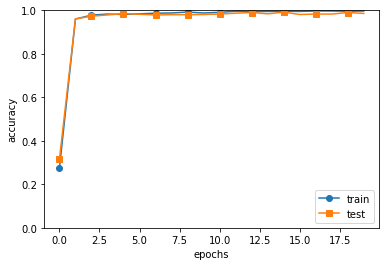

In [19]:
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show() 

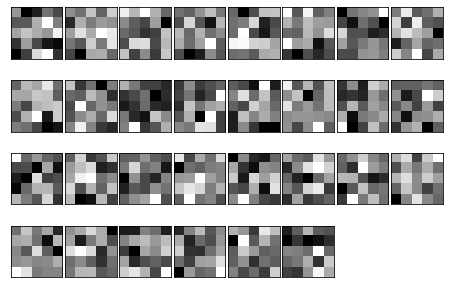

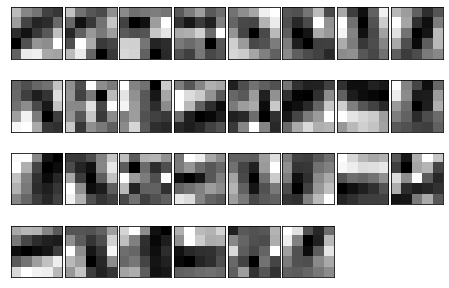

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])